In [1]:
pip install xgboost lightgbm catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 9.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 20.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/PS-S3/Ep7/train.csv'
file_key_2 = 'Tabular-Playground-Series/PS-S3/Ep7/test.csv'
file_key_3 = 'Tabular-Playground-Series/PS-S3/Ep7/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

train['low_price_flag'] = np.where(train['avg_price_per_room'] < 30, 1, 0)
# train['total_guests'] = train['no_of_adults'] + train['no_of_children']
# train['length_stay'] = train['no_of_weekend_nights'] + train['no_of_week_nights']

test['low_price_flag'] = np.where(test['avg_price_per_room'] < 30, 1, 0)
# test['total_guests'] = test['no_of_adults'] + test['no_of_children']

In [7]:
train['length_stay'].value_counts()

3     11843
4      8310
2      8282
1      5919
5      3717
7      1621
6      1531
8       255
10      152
9       139
0       114
11       48
14       39
13       33
12       29
15       27
16       11
18        8
21        6
20        6
17        4
23        2
22        2
19        2
Name: length_stay, dtype: int64

In [8]:
train.groupby('length_stay')['booking_status'].mean()

length_stay
0     0.175439
1     0.329448
2     0.397368
3     0.382589
4     0.403610
5     0.384988
6     0.464402
7     0.504627
8     0.521569
9     0.539568
10    0.585526
11    0.479167
12    0.448276
13    0.575758
14    0.461538
15    0.518519
16    0.272727
17    0.250000
18    0.375000
19    0.500000
20    0.333333
21    0.333333
22    1.000000
23    0.000000
Name: booking_status, dtype: float64

In [10]:
train.groupby('length_stay')['booking_status'].count()

length_stay
0       114
1      5919
2      8282
3     11843
4      8310
5      3717
6      1531
7      1621
8       255
9       139
10      152
11       48
12       29
13       33
14       39
15       27
16       11
17        4
18        8
19        2
20        6
21        6
22        2
23        2
Name: booking_status, dtype: int64

In [4]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,low_price_flag
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,0


In [12]:
zero_price = train[train['avg_price_per_room'] < 30].reset_index(drop = True)
zero_price.describe()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,21167.011445,1.493562,0.171674,0.371960,1.331903,0.377682,0.035765,1.111588,38.535050,2017.592275,8.054363,15.145923,2.819742,0.314735,0.150215,1.885551,0.621373,0.799714,0.057225
std,11857.874683,0.541569,0.578258,0.735208,1.252504,0.788793,0.185838,1.728447,75.725336,0.491764,3.501521,8.227698,1.495594,0.464743,0.767562,5.114288,2.934020,0.892471,0.232438
min,192.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11437.500000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2017.000000,5.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21133.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.000000,2018.000000,9.000000,15.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,31390.000000,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,38.000000,2018.000000,11.000000,21.000000,4.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,42017.000000,4.000000,4.000000,6.000000,16.000000,3.000000,1.000000,6.000000,386.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,11.000000,58.000000,24.670000,4.000000,1.000000


In [14]:
zero_price['booking_status'].value_counts() / zero_price.shape[0]

0    0.942775
1    0.057225
Name: booking_status, dtype: float64

In [16]:
positive_price = train[train['avg_price_per_room'] >= 30].reset_index(drop = True)
positive_price['booking_status'].value_counts() / positive_price.shape[0]

0    0.602328
1    0.397672
Name: booking_status, dtype: float64

In [3]:
positive_price = train[train['avg_price_per_room'] >= 30].reset_index(drop = True)
zero_price = train[train['avg_price_per_room'] < 30].reset_index(drop = True)

positive_price_agg = pd.DataFrame(positive_price.groupby(['arrival_year', 'arrival_month', 'arrival_date', 'room_type_reserved'])['avg_price_per_room'].mean())
positive_price_agg['arrival_year'] = positive_price_agg.index.get_level_values(0)
positive_price_agg['arrival_month'] = positive_price_agg.index.get_level_values(1)
positive_price_agg['arrival_date'] = positive_price_agg.index.get_level_values(2)
positive_price_agg['room_type_reserved'] = positive_price_agg.index.get_level_values(3)
positive_price_agg = positive_price_agg.reset_index(drop = True)

zero_price = pd.merge(zero_price.drop(columns = 'avg_price_per_room', axis = 1), positive_price_agg, on = ['arrival_year', 'arrival_month', 'arrival_date', 'room_type_reserved'], how = 'left')

train = pd.concat([positive_price, zero_price], axis = 0).reset_index(drop = True)

test_positive_price = test[test['avg_price_per_room'] > 30].reset_index(drop = True)
test_zero_price = test[test['avg_price_per_room'] <= 30].reset_index(drop = True)

positive_price_agg = pd.DataFrame(test_positive_price.groupby(['arrival_year', 'arrival_month', 'arrival_date', 'room_type_reserved'])['avg_price_per_room'].mean())
positive_price_agg['arrival_year'] = positive_price_agg.index.get_level_values(0)
positive_price_agg['arrival_month'] = positive_price_agg.index.get_level_values(1)
positive_price_agg['arrival_date'] = positive_price_agg.index.get_level_values(2)
positive_price_agg['room_type_reserved'] = positive_price_agg.index.get_level_values(3)
positive_price_agg = positive_price_agg.reset_index(drop = True)

test_zero_price = pd.merge(test_zero_price.drop(columns = 'avg_price_per_room', axis = 1), positive_price_agg, on = ['arrival_year', 'arrival_month', 'arrival_date', 'room_type_reserved'], how = 'left')

test = pd.concat([test_positive_price, test_zero_price], axis = 0).reset_index(drop = True)

In [ ]:
train.head()

In [ ]:
train.describe()

In [ ]:
test.describe()

In [2]:
train_lgb = train.copy()
test_lgb = test.copy()

X = train_lgb.drop(columns = ['id', 'booking_status'], axis = 1)
Y = train_lgb['booking_status']

test_lgb = test_lgb.drop(columns = ['id'], axis = 1)

In [3]:
X.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,low_price_flag
0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0
1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0
2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0
3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0
4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,0


In [20]:
test_lgb.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,low_price_flag
0,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2,0
1,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0,0
2,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1,0
3,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0,0
4,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0,0


In [ ]:
train.describe()

In [ ]:
test_lgb.describe()

# LightGBM Modeling

In [ ]:
cv_scores, roc_auc_scores = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 7880,
                                max_depth = 10,
                                learning_rate = 0.009689077948120357,
                                num_leaves = 20,
                                lambda_l1 = 1.2185030034603348,
                                lambda_l2 = 1.8144608820124146,
                                bagging_fraction = 0.6383698341881532,
                                feature_fraction = 0.5452440168291733).fit(X_train, Y_train)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test_lgb)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

lgb_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

# Optuna

In [21]:
class Objective:

    def __init__(self, seed):
        # Hold this implementation specific arguments as the fields of the class.
        self.seed = seed

    def __call__(self, trial):
        ## Parameters to be evaluated
        param = dict(objective = 'binary',
                     metric = 'auc',
                     tree_method = 'gbdt', 
                     n_estimators = trial.suggest_int('n_estimators', 300, 10000),
                     learning_rate = trial.suggest_float('learning_rate', 0.001, 1, log = True),
                     max_depth = trial.suggest_int('max_depth', 3, 12),
                     lambda_l1 = trial.suggest_float('lambda_l1', 0.01, 10.0, log = True),
                     lambda_l2 = trial.suggest_float('lambda_l2', 0.01, 10.0, log = True),
                     num_leaves = trial.suggest_int('num_leaves', 2, 100),
                     bagging_fraction = trial.suggest_float('bagging_fraction', 0.2, 0.9),
                     feature_fraction = trial.suggest_float('feature_fraction', 0.2, 0.9)
                    )

        scores = []
        
        skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = self.seed)
#         skf = KFold(n_splits = 5, shuffle = True, random_state = self.seed)

        for train_idx, valid_idx in skf.split(X, Y):

            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            Y_train , Y_valid = Y.iloc[train_idx] , Y.iloc[valid_idx]

            model = LGBMClassifier(**param).fit(X_train, Y_train)

#             preds_train = model.predict(X_train)
            preds_valid = model.predict_proba(X_valid)[:, 1]

            score = roc_auc_score(Y_valid, preds_valid)
            scores.append(score)

        return np.mean(scores)

In [22]:
N_TRIALS = 50
SEED = 42

study = optuna.create_study(direction = 'maximize')
study.optimize(Objective(SEED), n_trials = N_TRIALS)

[I 2023-02-15 05:19:09,324] A new study created in memory with name: no-name-8061a8e3-7a2a-48f7-ad3f-dfaf53e75a57


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.042922956747237805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.042922956747237805
[LightGBM] [Warning] feature_fraction is set=0.734285259695096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.734285259695096
[LightGBM] [Warning] lambda_l2 is set=0.8344669403439081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8344669403439081
[LightGBM] [Warning] bagging_fraction is set=0.45753001191099424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45753001191099424
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.042922956747237805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.042922956747237805
[LightGBM] [Warning] feature_fraction is set=0.734285259695096, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.734285259695096
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-15 05:19:18,574] Trial 0 finished with value: 0.8902038372994191 and parameters: {'n_estimators': 1090, 'learning_rate': 0.008720178264787914, 'max_depth': 5, 'lambda_l1': 0.042922956747237805, 'lambda_l2': 0.8344669403439081, 'num_leaves': 48, 'bagging_fraction': 0.45753001191099424, 'feature_fraction': 0.734285259695096}. Best is trial 0 with value: 0.8902038372994191.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.1519867782876925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1519867782876925
[LightGBM] [Warning] feature_fraction is set=0.40396705360519847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40396705360519847
[LightGBM] [Warning] lambda_l2 is set=0.01773347336024294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01773347336024294
[LightGBM] [Warning] bagging_fraction is set=0.6571809852841091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6571809852841091
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.1519867782876925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1519867782876925
[LightGBM] [Warning] feature_fraction is set=0.40396705360519847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40396705360519847
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-15 05:19:41,743] Trial 1 finished with value: 0.8715440227736204 and parameters: {'n_estimators': 3572, 'learning_rate': 0.8279639533984487, 'max_depth': 8, 'lambda_l1': 1.1519867782876925, 'lambda_l2': 0.01773347336024294, 'num_leaves': 33, 'bagging_fraction': 0.6571809852841091, 'feature_fraction': 0.40396705360519847}. Best is trial 0 with value: 0.8902038372994191.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03418425317678791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03418425317678791
[LightGBM] [Warning] feature_fraction is set=0.2956575056588752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2956575056588752
[LightGBM] [Warning] lambda_l2 is set=0.013680667791494306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013680667791494306
[LightGBM] [Warning] bagging_fraction is set=0.8933794751488835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8933794751488835
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03418425317678791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03418425317678791
[LightGBM] [Warning] feature_fraction is set=0.2956575056588752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2956575056588752
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-15 05:20:35,021] Trial 2 finished with value: 0.8900664585783622 and parameters: {'n_estimators': 8179, 'learning_rate': 0.0018098751450333747, 'max_depth': 12, 'lambda_l1': 0.03418425317678791, 'lambda_l2': 0.013680667791494306, 'num_leaves': 12, 'bagging_fraction': 0.8933794751488835, 'feature_fraction': 0.2956575056588752}. Best is trial 0 with value: 0.8902038372994191.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.17934455373684338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17934455373684338
[LightGBM] [Warning] feature_fraction is set=0.3354563733008074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3354563733008074
[LightGBM] [Warning] lambda_l2 is set=0.03485024689486541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03485024689486541
[LightGBM] [Warning] bagging_fraction is set=0.8995146584570681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8995146584570681
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.17934455373684338, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17934455373684338
[LightGBM] [Warning] feature_fraction is set=0.3354563733008074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3354563733008074
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-15 05:21:19,316] Trial 3 finished with value: 0.8965272312748697 and parameters: {'n_estimators': 5519, 'learning_rate': 0.005009301871992326, 'max_depth': 10, 'lambda_l1': 0.17934455373684338, 'lambda_l2': 0.03485024689486541, 'num_leaves': 26, 'bagging_fraction': 0.8995146584570681, 'feature_fraction': 0.3354563733008074}. Best is trial 3 with value: 0.8965272312748697.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.0650289737750784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0650289737750784
[LightGBM] [Warning] feature_fraction is set=0.3156617494155408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3156617494155408
[LightGBM] [Warning] lambda_l2 is set=0.08027025916760921, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08027025916760921
[LightGBM] [Warning] bagging_fraction is set=0.49150419930682965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49150419930682965
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.0650289737750784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0650289737750784
[LightGBM] [Warning] feature_fraction is set=0.3156617494155408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3156617494155408
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-15 05:21:40,057] Trial 4 finished with value: 0.8978680422979346 and parameters: {'n_estimators': 2950, 'learning_rate': 0.02146640189840897, 'max_depth': 12, 'lambda_l1': 0.0650289737750784, 'lambda_l2': 0.08027025916760921, 'num_leaves': 21, 'bagging_fraction': 0.49150419930682965, 'feature_fraction': 0.3156617494155408}. Best is trial 4 with value: 0.8978680422979346.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.337604203509746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.337604203509746
[LightGBM] [Warning] feature_fraction is set=0.30764597379081876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30764597379081876
[LightGBM] [Warning] lambda_l2 is set=2.0054971104982253, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0054971104982253
[LightGBM] [Warning] bagging_fraction is set=0.5023739511848648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5023739511848648
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.337604203509746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.337604203509746
[LightGBM] [Warning] feature_fraction is set=0.30764597379081876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30764597379081876
[LightGBM] [Warning] lambda_l2 is set=2.0

[I 2023-02-15 05:22:07,865] Trial 5 finished with value: 0.8890124482048349 and parameters: {'n_estimators': 5698, 'learning_rate': 0.356269291065736, 'max_depth': 12, 'lambda_l1': 1.337604203509746, 'lambda_l2': 2.0054971104982253, 'num_leaves': 20, 'bagging_fraction': 0.5023739511848648, 'feature_fraction': 0.30764597379081876}. Best is trial 4 with value: 0.8978680422979346.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.48926043686578036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48926043686578036
[LightGBM] [Warning] feature_fraction is set=0.7300113458115285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7300113458115285
[LightGBM] [Warning] lambda_l2 is set=0.20490930834557286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20490930834557286
[LightGBM] [Warning] bagging_fraction is set=0.5839197212980063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5839197212980063
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.48926043686578036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.48926043686578036
[LightGBM] [Warning] feature_fraction is set=0.7300113458115285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7300113458115285
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-15 05:22:55,952] Trial 6 finished with value: 0.8745691647633438 and parameters: {'n_estimators': 5539, 'learning_rate': 0.20180108549637857, 'max_depth': 8, 'lambda_l1': 0.48926043686578036, 'lambda_l2': 0.20490930834557286, 'num_leaves': 33, 'bagging_fraction': 0.5839197212980063, 'feature_fraction': 0.7300113458115285}. Best is trial 4 with value: 0.8978680422979346.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.08901289941797771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08901289941797771
[LightGBM] [Warning] feature_fraction is set=0.7226825507268664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7226825507268664
[LightGBM] [Warning] lambda_l2 is set=0.01469491302321305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01469491302321305
[LightGBM] [Warning] bagging_fraction is set=0.8103209117893568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8103209117893568
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.08901289941797771, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08901289941797771
[LightGBM] [Warning] feature_fraction is set=0.7226825507268664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7226825507268664
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-15 05:24:46,327] Trial 7 finished with value: 0.8663404588399203 and parameters: {'n_estimators': 7560, 'learning_rate': 0.13514599933975913, 'max_depth': 7, 'lambda_l1': 0.08901289941797771, 'lambda_l2': 0.01469491302321305, 'num_leaves': 88, 'bagging_fraction': 0.8103209117893568, 'feature_fraction': 0.7226825507268664}. Best is trial 4 with value: 0.8978680422979346.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.18819741679579793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18819741679579793
[LightGBM] [Warning] feature_fraction is set=0.7245919328967001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7245919328967001
[LightGBM] [Warning] lambda_l2 is set=0.034628626548331265, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034628626548331265
[LightGBM] [Warning] bagging_fraction is set=0.8193231524224118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8193231524224118
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.18819741679579793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18819741679579793
[LightGBM] [Warning] feature_fraction is set=0.7245919328967001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7245919328967001
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-15 05:26:12,270] Trial 8 finished with value: 0.8749666443790687 and parameters: {'n_estimators': 6098, 'learning_rate': 0.07446416305317369, 'max_depth': 9, 'lambda_l1': 0.18819741679579793, 'lambda_l2': 0.034628626548331265, 'num_leaves': 67, 'bagging_fraction': 0.8193231524224118, 'feature_fraction': 0.7245919328967001}. Best is trial 4 with value: 0.8978680422979346.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.4343007400000185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4343007400000185
[LightGBM] [Warning] feature_fraction is set=0.29190676287540945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29190676287540945
[LightGBM] [Warning] lambda_l2 is set=2.4712185408144425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4712185408144425
[LightGBM] [Warning] bagging_fraction is set=0.6704473114789922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6704473114789922
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.4343007400000185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4343007400000185
[LightGBM] [Warning] feature_fraction is set=0.29190676287540945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29190676287540945
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-15 05:26:58,432] Trial 9 finished with value: 0.9004093855164221 and parameters: {'n_estimators': 9691, 'learning_rate': 0.0462768823884295, 'max_depth': 6, 'lambda_l1': 3.4343007400000185, 'lambda_l2': 2.4712185408144425, 'num_leaves': 55, 'bagging_fraction': 0.6704473114789922, 'feature_fraction': 0.29190676287540945}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=8.551880567150858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.551880567150858
[LightGBM] [Warning] feature_fraction is set=0.20831606141959985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20831606141959985
[LightGBM] [Warning] lambda_l2 is set=8.403033534081825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.403033534081825
[LightGBM] [Warning] bagging_fraction is set=0.268830511669942, subsample=1.0 will be ignored. Current value: bagging_fraction=0.268830511669942
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=8.551880567150858, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.551880567150858
[LightGBM] [Warning] feature_fraction is set=0.20831606141959985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20831606141959985
[LightGBM] [Warning] lambda_l2 is set=8.40303

[I 2023-02-15 05:27:38,074] Trial 10 finished with value: 0.8946402351117314 and parameters: {'n_estimators': 9184, 'learning_rate': 0.04295127770504357, 'max_depth': 3, 'lambda_l1': 8.551880567150858, 'lambda_l2': 8.403033534081825, 'num_leaves': 67, 'bagging_fraction': 0.268830511669942, 'feature_fraction': 0.20831606141959985}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.012846649136128914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012846649136128914
[LightGBM] [Warning] feature_fraction is set=0.4962728141688117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4962728141688117
[LightGBM] [Warning] lambda_l2 is set=0.16976262044253493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16976262044253493
[LightGBM] [Warning] bagging_fraction is set=0.6545141321633466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6545141321633466
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.012846649136128914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012846649136128914
[LightGBM] [Warning] feature_fraction is set=0.4962728141688117, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4962728141688117
[LightGBM] [Warning] lambda_l2 

[I 2023-02-15 05:28:04,908] Trial 11 finished with value: 0.8988143323522847 and parameters: {'n_estimators': 2533, 'learning_rate': 0.026973690950933108, 'max_depth': 6, 'lambda_l1': 0.012846649136128914, 'lambda_l2': 0.16976262044253493, 'num_leaves': 57, 'bagging_fraction': 0.6545141321633466, 'feature_fraction': 0.4962728141688117}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.01378703506379495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01378703506379495
[LightGBM] [Warning] feature_fraction is set=0.5193480358841259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5193480358841259
[LightGBM] [Warning] lambda_l2 is set=0.3280617752040292, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3280617752040292
[LightGBM] [Warning] bagging_fraction is set=0.6956636424383477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6956636424383477
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.01378703506379495, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01378703506379495
[LightGBM] [Warning] feature_fraction is set=0.5193480358841259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5193480358841259
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-15 05:28:07,959] Trial 12 finished with value: 0.8895138980680322 and parameters: {'n_estimators': 318, 'learning_rate': 0.024085533960571563, 'max_depth': 5, 'lambda_l1': 0.01378703506379495, 'lambda_l2': 0.3280617752040292, 'num_leaves': 57, 'bagging_fraction': 0.6956636424383477, 'feature_fraction': 0.5193480358841259}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.010641018077380486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010641018077380486
[LightGBM] [Warning] feature_fraction is set=0.49506879918275926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49506879918275926
[LightGBM] [Warning] lambda_l2 is set=1.9193187427127016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9193187427127016
[LightGBM] [Warning] bagging_fraction is set=0.6875678471919009, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6875678471919009
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.010641018077380486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010641018077380486
[LightGBM] [Warning] feature_fraction is set=0.49506879918275926, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49506879918275926
[LightGBM] [Warning] lambda_l

[I 2023-02-15 05:28:43,628] Trial 13 finished with value: 0.8953257586203189 and parameters: {'n_estimators': 3059, 'learning_rate': 0.05783517398871936, 'max_depth': 6, 'lambda_l1': 0.010641018077380486, 'lambda_l2': 1.9193187427127016, 'num_leaves': 92, 'bagging_fraction': 0.6875678471919009, 'feature_fraction': 0.49506879918275926}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=9.627620320892575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.627620320892575
[LightGBM] [Warning] feature_fraction is set=0.5652553817287693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5652553817287693
[LightGBM] [Warning] lambda_l2 is set=0.2079074801768107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2079074801768107
[LightGBM] [Warning] bagging_fraction is set=0.5971679614786078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5971679614786078
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=9.627620320892575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.627620320892575
[LightGBM] [Warning] feature_fraction is set=0.5652553817287693, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5652553817287693
[LightGBM] [Warning] lambda_l2 is set=0.20790

[I 2023-02-15 05:29:29,475] Trial 14 finished with value: 0.8954737572742282 and parameters: {'n_estimators': 9896, 'learning_rate': 0.014059036869355857, 'max_depth': 3, 'lambda_l1': 9.627620320892575, 'lambda_l2': 0.2079074801768107, 'num_leaves': 47, 'bagging_fraction': 0.5971679614786078, 'feature_fraction': 0.5652553817287693}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.022705292776502906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022705292776502906
[LightGBM] [Warning] feature_fraction is set=0.2011139378259144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2011139378259144
[LightGBM] [Warning] lambda_l2 is set=0.5762138271005658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5762138271005658
[LightGBM] [Warning] bagging_fraction is set=0.7432345894647586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7432345894647586
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.022705292776502906, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022705292776502906
[LightGBM] [Warning] feature_fraction is set=0.2011139378259144, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2011139378259144
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-15 05:29:43,183] Trial 15 finished with value: 0.89389811563567 and parameters: {'n_estimators': 1783, 'learning_rate': 0.03552273252513722, 'max_depth': 5, 'lambda_l1': 0.022705292776502906, 'lambda_l2': 0.5762138271005658, 'num_leaves': 75, 'bagging_fraction': 0.7432345894647586, 'feature_fraction': 0.2011139378259144}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.010609282280372619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010609282280372619
[LightGBM] [Warning] feature_fraction is set=0.8547127174965037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8547127174965037
[LightGBM] [Warning] lambda_l2 is set=0.11026493745883226, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11026493745883226
[LightGBM] [Warning] bagging_fraction is set=0.5953570077226663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5953570077226663
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.010609282280372619, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010609282280372619
[LightGBM] [Warning] feature_fraction is set=0.8547127174965037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8547127174965037
[LightGBM] [Warning] lambda_l2 

[I 2023-02-15 05:30:22,393] Trial 16 finished with value: 0.879655783115088 and parameters: {'n_estimators': 4150, 'learning_rate': 0.0870523351633551, 'max_depth': 6, 'lambda_l1': 0.010609282280372619, 'lambda_l2': 0.11026493745883226, 'num_leaves': 55, 'bagging_fraction': 0.5953570077226663, 'feature_fraction': 0.8547127174965037}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.32532794226224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32532794226224
[LightGBM] [Warning] feature_fraction is set=0.43709060024500823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43709060024500823
[LightGBM] [Warning] lambda_l2 is set=8.962046635660519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.962046635660519
[LightGBM] [Warning] bagging_fraction is set=0.41457964940935127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41457964940935127
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=3.32532794226224, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.32532794226224
[LightGBM] [Warning] feature_fraction is set=0.43709060024500823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43709060024500823
[LightGBM] [Warning] lambda_l2 is set=8.96204

[I 2023-02-15 05:31:10,174] Trial 17 finished with value: 0.8969500404744416 and parameters: {'n_estimators': 6927, 'learning_rate': 0.007607023078060199, 'max_depth': 4, 'lambda_l1': 3.32532794226224, 'lambda_l2': 8.962046635660519, 'num_leaves': 82, 'bagging_fraction': 0.41457964940935127, 'feature_fraction': 0.43709060024500823}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.45584145375928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45584145375928
[LightGBM] [Warning] feature_fraction is set=0.5975148286282538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975148286282538
[LightGBM] [Warning] lambda_l2 is set=1.4828770421303648, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4828770421303648
[LightGBM] [Warning] bagging_fraction is set=0.7542214307958157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7542214307958157
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.45584145375928, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45584145375928
[LightGBM] [Warning] feature_fraction is set=0.5975148286282538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5975148286282538
[LightGBM] [Warning] lambda_l2 is set=1.482877042

[I 2023-02-15 05:32:01,226] Trial 18 finished with value: 0.8949733330401382 and parameters: {'n_estimators': 4386, 'learning_rate': 0.030775588625469287, 'max_depth': 7, 'lambda_l1': 0.45584145375928, 'lambda_l2': 1.4828770421303648, 'num_leaves': 43, 'bagging_fraction': 0.7542214307958157, 'feature_fraction': 0.5975148286282538}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.12207981392410137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12207981392410137
[LightGBM] [Warning] feature_fraction is set=0.37678525065532725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37678525065532725
[LightGBM] [Warning] lambda_l2 is set=3.6414616590236295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6414616590236295
[LightGBM] [Warning] bagging_fraction is set=0.6205386274191405, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6205386274191405
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.12207981392410137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12207981392410137
[LightGBM] [Warning] feature_fraction is set=0.37678525065532725, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37678525065532725
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-15 05:32:31,113] Trial 19 finished with value: 0.8884795668891645 and parameters: {'n_estimators': 1968, 'learning_rate': 0.12239248286594015, 'max_depth': 10, 'lambda_l1': 0.12207981392410137, 'lambda_l2': 3.6414616590236295, 'num_leaves': 64, 'bagging_fraction': 0.6205386274191405, 'feature_fraction': 0.37678525065532725}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.2904912556686908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2904912556686908
[LightGBM] [Warning] feature_fraction is set=0.4699564699936937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4699564699936937
[LightGBM] [Warning] lambda_l2 is set=0.5831527477144084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5831527477144084
[LightGBM] [Warning] bagging_fraction is set=0.549928439058873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.549928439058873
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.2904912556686908, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2904912556686908
[LightGBM] [Warning] feature_fraction is set=0.4699564699936937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4699564699936937
[LightGBM] [Warning] lambda_l2 is set=0.583

[I 2023-02-15 05:33:59,780] Trial 20 finished with value: 0.8971387499151715 and parameters: {'n_estimators': 8249, 'learning_rate': 0.014447104693102862, 'max_depth': 6, 'lambda_l1': 0.2904912556686908, 'lambda_l2': 0.5831527477144084, 'num_leaves': 76, 'bagging_fraction': 0.549928439058873, 'feature_fraction': 0.4699564699936937}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.052781625327601514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.052781625327601514
[LightGBM] [Warning] feature_fraction is set=0.26160171265521504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26160171265521504
[LightGBM] [Warning] lambda_l2 is set=0.11700035430130956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11700035430130956
[LightGBM] [Warning] bagging_fraction is set=0.503426696623393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.503426696623393
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.052781625327601514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.052781625327601514
[LightGBM] [Warning] feature_fraction is set=0.26160171265521504, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26160171265521504
[LightGBM] [Warning] lambda_l

[I 2023-02-15 05:34:14,305] Trial 21 finished with value: 0.8932154298289092 and parameters: {'n_estimators': 2591, 'learning_rate': 0.02121472527771325, 'max_depth': 11, 'lambda_l1': 0.052781625327601514, 'lambda_l2': 0.11700035430130956, 'num_leaves': 6, 'bagging_fraction': 0.503426696623393, 'feature_fraction': 0.26160171265521504}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.07590019645402839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07590019645402839
[LightGBM] [Warning] feature_fraction is set=0.4142959358360944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4142959358360944
[LightGBM] [Warning] lambda_l2 is set=0.07612640897818143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07612640897818143
[LightGBM] [Warning] bagging_fraction is set=0.6469869084360182, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6469869084360182
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.07590019645402839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07590019645402839
[LightGBM] [Warning] feature_fraction is set=0.4142959358360944, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4142959358360944
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-15 05:35:07,232] Trial 22 finished with value: 0.8912340663188736 and parameters: {'n_estimators': 4537, 'learning_rate': 0.050712590034798014, 'max_depth': 9, 'lambda_l1': 0.07590019645402839, 'lambda_l2': 0.07612640897818143, 'num_leaves': 36, 'bagging_fraction': 0.6469869084360182, 'feature_fraction': 0.4142959358360944}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.019372429023403664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019372429023403664
[LightGBM] [Warning] feature_fraction is set=0.3622109937637028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3622109937637028
[LightGBM] [Warning] lambda_l2 is set=0.3286837361752886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3286837361752886
[LightGBM] [Warning] bagging_fraction is set=0.5459349739709711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5459349739709711
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.019372429023403664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019372429023403664
[LightGBM] [Warning] feature_fraction is set=0.3622109937637028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3622109937637028
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-15 05:35:44,150] Trial 23 finished with value: 0.8992263283874374 and parameters: {'n_estimators': 2616, 'learning_rate': 0.02104766445806309, 'max_depth': 7, 'lambda_l1': 0.019372429023403664, 'lambda_l2': 0.3286837361752886, 'num_leaves': 100, 'bagging_fraction': 0.5459349739709711, 'feature_fraction': 0.3622109937637028}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.02732984982433951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02732984982433951
[LightGBM] [Warning] feature_fraction is set=0.37035968006230763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37035968006230763
[LightGBM] [Warning] lambda_l2 is set=0.2949866043039955, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2949866043039955
[LightGBM] [Warning] bagging_fraction is set=0.5546572631892964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5546572631892964
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.02732984982433951, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02732984982433951
[LightGBM] [Warning] feature_fraction is set=0.37035968006230763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37035968006230763
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-15 05:36:09,767] Trial 24 finished with value: 0.8963587389582222 and parameters: {'n_estimators': 1796, 'learning_rate': 0.04907217514435997, 'max_depth': 7, 'lambda_l1': 0.02732984982433951, 'lambda_l2': 0.2949866043039955, 'num_leaves': 94, 'bagging_fraction': 0.5546572631892964, 'feature_fraction': 0.37035968006230763}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.019616562649510238, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019616562649510238
[LightGBM] [Warning] feature_fraction is set=0.45015477300715184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45015477300715184
[LightGBM] [Warning] lambda_l2 is set=0.9071304852750205, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9071304852750205
[LightGBM] [Warning] bagging_fraction is set=0.6916864599479388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6916864599479388
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.019616562649510238, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019616562649510238
[LightGBM] [Warning] feature_fraction is set=0.45015477300715184, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45015477300715184
[LightGBM] [Warning] lambda_l

[I 2023-02-15 05:36:55,541] Trial 25 finished with value: 0.894993631138805 and parameters: {'n_estimators': 6546, 'learning_rate': 0.004337527614758143, 'max_depth': 4, 'lambda_l1': 0.019616562649510238, 'lambda_l2': 0.9071304852750205, 'num_leaves': 97, 'bagging_fraction': 0.6916864599479388, 'feature_fraction': 0.45015477300715184}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.021162665170399622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021162665170399622
[LightGBM] [Warning] feature_fraction is set=0.3527470966108979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3527470966108979
[LightGBM] [Warning] lambda_l2 is set=0.4317468793779342, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4317468793779342
[LightGBM] [Warning] bagging_fraction is set=0.6383251705607326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6383251705607326
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.021162665170399622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.021162665170399622
[LightGBM] [Warning] feature_fraction is set=0.3527470966108979, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3527470966108979
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-15 05:37:01,664] Trial 26 finished with value: 0.8870280984604332 and parameters: {'n_estimators': 517, 'learning_rate': 0.014952681310042305, 'max_depth': 6, 'lambda_l1': 0.021162665170399622, 'lambda_l2': 0.4317468793779342, 'num_leaves': 59, 'bagging_fraction': 0.6383251705607326, 'feature_fraction': 0.3527470966108979}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.04130907662546572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04130907662546572
[LightGBM] [Warning] feature_fraction is set=0.263881688775358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.263881688775358
[LightGBM] [Warning] lambda_l2 is set=1.0014613926023916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0014613926023916
[LightGBM] [Warning] bagging_fraction is set=0.40005724303424767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40005724303424767
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.04130907662546572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04130907662546572
[LightGBM] [Warning] feature_fraction is set=0.263881688775358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.263881688775358
[LightGBM] [Warning] lambda_l2 is set=1

[I 2023-02-15 05:37:56,011] Trial 27 finished with value: 0.896260687612914 and parameters: {'n_estimators': 3611, 'learning_rate': 0.028647812456863056, 'max_depth': 8, 'lambda_l1': 0.04130907662546572, 'lambda_l2': 1.0014613926023916, 'num_leaves': 76, 'bagging_fraction': 0.40005724303424767, 'feature_fraction': 0.263881688775358}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.01738197825053007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01738197825053007
[LightGBM] [Warning] feature_fraction is set=0.40078815766818116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40078815766818116
[LightGBM] [Warning] lambda_l2 is set=4.3720356326102845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3720356326102845
[LightGBM] [Warning] bagging_fraction is set=0.5694899140134363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5694899140134363
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.01738197825053007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01738197825053007
[LightGBM] [Warning] feature_fraction is set=0.40078815766818116, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40078815766818116
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-15 05:38:11,613] Trial 28 finished with value: 0.8996443735949768 and parameters: {'n_estimators': 2337, 'learning_rate': 0.07472980180414668, 'max_depth': 4, 'lambda_l1': 0.01738197825053007, 'lambda_l2': 4.3720356326102845, 'num_leaves': 40, 'bagging_fraction': 0.5694899140134363, 'feature_fraction': 0.40078815766818116}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.032856665436421406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032856665436421406
[LightGBM] [Warning] feature_fraction is set=0.37290969660843365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37290969660843365
[LightGBM] [Warning] lambda_l2 is set=3.933870013173166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.933870013173166
[LightGBM] [Warning] bagging_fraction is set=0.5469098059779328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5469098059779328
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.032856665436421406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032856665436421406
[LightGBM] [Warning] feature_fraction is set=0.37290969660843365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.37290969660843365
[LightGBM] [Warning] lambda_l2 

[I 2023-02-15 05:38:19,953] Trial 29 finished with value: 0.8988999916976222 and parameters: {'n_estimators': 1131, 'learning_rate': 0.07224252822082672, 'max_depth': 4, 'lambda_l1': 0.032856665436421406, 'lambda_l2': 3.933870013173166, 'num_leaves': 39, 'bagging_fraction': 0.5469098059779328, 'feature_fraction': 0.37290969660843365}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.0496710182233287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0496710182233287
[LightGBM] [Warning] feature_fraction is set=0.4116253346284611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4116253346284611
[LightGBM] [Warning] lambda_l2 is set=4.321656147736103, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.321656147736103
[LightGBM] [Warning] bagging_fraction is set=0.4794792477315061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4794792477315061
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.0496710182233287, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0496710182233287
[LightGBM] [Warning] feature_fraction is set=0.4116253346284611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4116253346284611
[LightGBM] [Warning] lambda_l2 is set=4.321

[I 2023-02-15 05:38:32,044] Trial 30 finished with value: 0.8955385489774118 and parameters: {'n_estimators': 1346, 'learning_rate': 0.21242733944598813, 'max_depth': 5, 'lambda_l1': 0.0496710182233287, 'lambda_l2': 4.321656147736103, 'num_leaves': 50, 'bagging_fraction': 0.4794792477315061, 'feature_fraction': 0.4116253346284611}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03566893906668489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03566893906668489
[LightGBM] [Warning] feature_fraction is set=0.3460515292560105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3460515292560105
[LightGBM] [Warning] lambda_l2 is set=3.746572741202656, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.746572741202656
[LightGBM] [Warning] bagging_fraction is set=0.5458714676889129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5458714676889129
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03566893906668489, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03566893906668489
[LightGBM] [Warning] feature_fraction is set=0.3460515292560105, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3460515292560105
[LightGBM] [Warning] lambda_l2 is set=3

[I 2023-02-15 05:38:45,941] Trial 31 finished with value: 0.8981389439427379 and parameters: {'n_estimators': 2089, 'learning_rate': 0.07020659128572292, 'max_depth': 4, 'lambda_l1': 0.03566893906668489, 'lambda_l2': 3.746572741202656, 'num_leaves': 40, 'bagging_fraction': 0.5458714676889129, 'feature_fraction': 0.3460515292560105}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.01777694168725253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01777694168725253
[LightGBM] [Warning] feature_fraction is set=0.39088270387711965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39088270387711965
[LightGBM] [Warning] lambda_l2 is set=5.13871281304424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.13871281304424
[LightGBM] [Warning] bagging_fraction is set=0.5409025348267552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5409025348267552
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.01777694168725253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01777694168725253
[LightGBM] [Warning] feature_fraction is set=0.39088270387711965, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39088270387711965
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-15 05:38:53,001] Trial 32 finished with value: 0.8989563009091082 and parameters: {'n_estimators': 945, 'learning_rate': 0.11733453182413696, 'max_depth': 4, 'lambda_l1': 0.01777694168725253, 'lambda_l2': 5.13871281304424, 'num_leaves': 24, 'bagging_fraction': 0.5409025348267552, 'feature_fraction': 0.39088270387711965}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.016014727017857843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016014727017857843
[LightGBM] [Warning] feature_fraction is set=0.3960313714064794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3960313714064794
[LightGBM] [Warning] lambda_l2 is set=5.8365531804030155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.8365531804030155
[LightGBM] [Warning] bagging_fraction is set=0.4399561513337205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4399561513337205
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.016014727017857843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016014727017857843
[LightGBM] [Warning] feature_fraction is set=0.3960313714064794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3960313714064794
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-15 05:38:58,399] Trial 33 finished with value: 0.897898456830619 and parameters: {'n_estimators': 969, 'learning_rate': 0.12646959008003275, 'max_depth': 3, 'lambda_l1': 0.016014727017857843, 'lambda_l2': 5.8365531804030155, 'num_leaves': 27, 'bagging_fraction': 0.4399561513337205, 'feature_fraction': 0.3960313714064794}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.02295431124240094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02295431124240094
[LightGBM] [Warning] feature_fraction is set=0.26885643976194684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26885643976194684
[LightGBM] [Warning] lambda_l2 is set=2.314430971640147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.314430971640147
[LightGBM] [Warning] bagging_fraction is set=0.5915842072131681, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5915842072131681
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.02295431124240094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02295431124240094
[LightGBM] [Warning] feature_fraction is set=0.26885643976194684, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26885643976194684
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-15 05:39:19,897] Trial 34 finished with value: 0.8992842307980897 and parameters: {'n_estimators': 3293, 'learning_rate': 0.03790661974003276, 'max_depth': 5, 'lambda_l1': 0.02295431124240094, 'lambda_l2': 2.314430971640147, 'num_leaves': 12, 'bagging_fraction': 0.5915842072131681, 'feature_fraction': 0.26885643976194684}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.024421988780121563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024421988780121563
[LightGBM] [Warning] feature_fraction is set=0.27414064539374716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27414064539374716
[LightGBM] [Warning] lambda_l2 is set=2.139441374842394, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.139441374842394
[LightGBM] [Warning] bagging_fraction is set=0.6176444123411382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6176444123411382
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.024421988780121563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024421988780121563
[LightGBM] [Warning] feature_fraction is set=0.27414064539374716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27414064539374716
[LightGBM] [Warning] lambda_l2 

[I 2023-02-15 05:39:35,250] Trial 35 finished with value: 0.8714193388839131 and parameters: {'n_estimators': 3642, 'learning_rate': 0.04361469171731591, 'max_depth': 5, 'lambda_l1': 0.024421988780121563, 'lambda_l2': 2.139441374842394, 'num_leaves': 2, 'bagging_fraction': 0.6176444123411382, 'feature_fraction': 0.27414064539374716}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.04247405656646707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04247405656646707
[LightGBM] [Warning] feature_fraction is set=0.3166073397583073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3166073397583073
[LightGBM] [Warning] lambda_l2 is set=1.2762306324040358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2762306324040358
[LightGBM] [Warning] bagging_fraction is set=0.5898274019272143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5898274019272143
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.04247405656646707, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04247405656646707
[LightGBM] [Warning] feature_fraction is set=0.3166073397583073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3166073397583073
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-15 05:40:04,290] Trial 36 finished with value: 0.8975429241439148 and parameters: {'n_estimators': 4819, 'learning_rate': 0.036351050382994146, 'max_depth': 7, 'lambda_l1': 0.04247405656646707, 'lambda_l2': 1.2762306324040358, 'num_leaves': 9, 'bagging_fraction': 0.5898274019272143, 'feature_fraction': 0.3166073397583073}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06450880338855397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06450880338855397
[LightGBM] [Warning] feature_fraction is set=0.23528471058425113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23528471058425113
[LightGBM] [Warning] lambda_l2 is set=2.302368519081836, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.302368519081836
[LightGBM] [Warning] bagging_fraction is set=0.5138245344832318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5138245344832318
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06450880338855397, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06450880338855397
[LightGBM] [Warning] feature_fraction is set=0.23528471058425113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23528471058425113
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-15 05:40:23,446] Trial 37 finished with value: 0.8813962270806661 and parameters: {'n_estimators': 2983, 'learning_rate': 0.712724048021082, 'max_depth': 5, 'lambda_l1': 0.06450880338855397, 'lambda_l2': 2.302368519081836, 'num_leaves': 16, 'bagging_fraction': 0.5138245344832318, 'feature_fraction': 0.23528471058425113}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.010251448423139374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010251448423139374
[LightGBM] [Warning] feature_fraction is set=0.2877075746501148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2877075746501148
[LightGBM] [Warning] lambda_l2 is set=0.6939141727632362, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6939141727632362
[LightGBM] [Warning] bagging_fraction is set=0.4699104886636518, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4699104886636518
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.010251448423139374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010251448423139374
[LightGBM] [Warning] feature_fraction is set=0.2877075746501148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2877075746501148
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-15 05:40:57,416] Trial 38 finished with value: 0.8977160942995607 and parameters: {'n_estimators': 3728, 'learning_rate': 0.010028305351081165, 'max_depth': 6, 'lambda_l1': 0.010251448423139374, 'lambda_l2': 0.6939141727632362, 'num_leaves': 18, 'bagging_fraction': 0.4699104886636518, 'feature_fraction': 0.2877075746501148}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03025937948253207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03025937948253207
[LightGBM] [Warning] feature_fraction is set=0.3282429539681161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3282429539681161
[LightGBM] [Warning] lambda_l2 is set=2.7263209684734564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7263209684734564
[LightGBM] [Warning] bagging_fraction is set=0.6703335799261161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6703335799261161
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03025937948253207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03025937948253207
[LightGBM] [Warning] feature_fraction is set=0.3282429539681161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3282429539681161
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-15 05:41:48,796] Trial 39 finished with value: 0.8979199168631314 and parameters: {'n_estimators': 5288, 'learning_rate': 0.017997627265466887, 'max_depth': 9, 'lambda_l1': 0.03025937948253207, 'lambda_l2': 2.7263209684734564, 'num_leaves': 30, 'bagging_fraction': 0.6703335799261161, 'feature_fraction': 0.3282429539681161}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.10840355719351985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10840355719351985
[LightGBM] [Warning] feature_fraction is set=0.3051658685812052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3051658685812052
[LightGBM] [Warning] lambda_l2 is set=2.9573119756337327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9573119756337327
[LightGBM] [Warning] bagging_fraction is set=0.5813746880257094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5813746880257094
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.10840355719351985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10840355719351985
[LightGBM] [Warning] feature_fraction is set=0.3051658685812052, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3051658685812052
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-15 05:42:15,431] Trial 40 finished with value: 0.8977024973293855 and parameters: {'n_estimators': 2448, 'learning_rate': 0.053476377762798136, 'max_depth': 8, 'lambda_l1': 0.10840355719351985, 'lambda_l2': 2.9573119756337327, 'num_leaves': 45, 'bagging_fraction': 0.5813746880257094, 'feature_fraction': 0.3051658685812052}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.018701916871642802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018701916871642802
[LightGBM] [Warning] feature_fraction is set=0.3329031861092038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3329031861092038
[LightGBM] [Warning] lambda_l2 is set=7.0046255860473545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.0046255860473545
[LightGBM] [Warning] bagging_fraction is set=0.5194445915410761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5194445915410761
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.018701916871642802, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018701916871642802
[LightGBM] [Warning] feature_fraction is set=0.3329031861092038, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3329031861092038
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-15 05:42:35,615] Trial 41 finished with value: 0.8980891469105753 and parameters: {'n_estimators': 3154, 'learning_rate': 0.08206383707085872, 'max_depth': 4, 'lambda_l1': 0.018701916871642802, 'lambda_l2': 7.0046255860473545, 'num_leaves': 24, 'bagging_fraction': 0.5194445915410761, 'feature_fraction': 0.3329031861092038}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.01567551333418769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01567551333418769
[LightGBM] [Warning] feature_fraction is set=0.2462250016604327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2462250016604327
[LightGBM] [Warning] lambda_l2 is set=5.127236976379271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.127236976379271
[LightGBM] [Warning] bagging_fraction is set=0.5774958233365137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774958233365137
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.01567551333418769, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01567551333418769
[LightGBM] [Warning] feature_fraction is set=0.2462250016604327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2462250016604327
[LightGBM] [Warning] lambda_l2 is set=5

[I 2023-02-15 05:42:45,290] Trial 42 finished with value: 0.8943677742633636 and parameters: {'n_estimators': 1444, 'learning_rate': 0.11174665206563895, 'max_depth': 5, 'lambda_l1': 0.01567551333418769, 'lambda_l2': 5.127236976379271, 'num_leaves': 12, 'bagging_fraction': 0.5774958233365137, 'feature_fraction': 0.2462250016604327}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.016029729015959126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016029729015959126
[LightGBM] [Warning] feature_fraction is set=0.28375954744008847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28375954744008847
[LightGBM] [Warning] lambda_l2 is set=9.431190973866398, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.431190973866398
[LightGBM] [Warning] bagging_fraction is set=0.6220569767871599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6220569767871599
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.016029729015959126, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016029729015959126
[LightGBM] [Warning] feature_fraction is set=0.28375954744008847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.28375954744008847
[LightGBM] [Warning] lambda_l2 

[I 2023-02-15 05:42:49,496] Trial 43 finished with value: 0.8980646023761292 and parameters: {'n_estimators': 623, 'learning_rate': 0.17526044652832848, 'max_depth': 4, 'lambda_l1': 0.016029729015959126, 'lambda_l2': 9.431190973866398, 'num_leaves': 32, 'bagging_fraction': 0.6220569767871599, 'feature_fraction': 0.28375954744008847}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.028367376264655613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.028367376264655613
[LightGBM] [Warning] feature_fraction is set=0.2272646459916593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2272646459916593
[LightGBM] [Warning] lambda_l2 is set=6.259848671393187, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.259848671393187
[LightGBM] [Warning] bagging_fraction is set=0.5449452828219629, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5449452828219629
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.028367376264655613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.028367376264655613
[LightGBM] [Warning] feature_fraction is set=0.2272646459916593, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2272646459916593
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-15 05:43:02,698] Trial 44 finished with value: 0.8898355403730493 and parameters: {'n_estimators': 2458, 'learning_rate': 0.03587688255690074, 'max_depth': 3, 'lambda_l1': 0.028367376264655613, 'lambda_l2': 6.259848671393187, 'num_leaves': 23, 'bagging_fraction': 0.5449452828219629, 'feature_fraction': 0.2272646459916593}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.05607187426828255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05607187426828255
[LightGBM] [Warning] feature_fraction is set=0.3061649302774931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3061649302774931
[LightGBM] [Warning] lambda_l2 is set=1.6430437111729246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6430437111729246
[LightGBM] [Warning] bagging_fraction is set=0.6597214136830669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6597214136830669
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.05607187426828255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05607187426828255
[LightGBM] [Warning] feature_fraction is set=0.3061649302774931, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3061649302774931
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-15 05:44:07,337] Trial 45 finished with value: 0.8889552869940974 and parameters: {'n_estimators': 8892, 'learning_rate': 0.09598346640671584, 'max_depth': 5, 'lambda_l1': 0.05607187426828255, 'lambda_l2': 1.6430437111729246, 'num_leaves': 16, 'bagging_fraction': 0.6597214136830669, 'feature_fraction': 0.3061649302774931}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.7965240040635698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7965240040635698
[LightGBM] [Warning] feature_fraction is set=0.34971946676665777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34971946676665777
[LightGBM] [Warning] lambda_l2 is set=1.220772002639606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.220772002639606
[LightGBM] [Warning] bagging_fraction is set=0.5128411534772048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5128411534772048
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.7965240040635698, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7965240040635698
[LightGBM] [Warning] feature_fraction is set=0.34971946676665777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34971946676665777
[LightGBM] [Warning] lambda_l2 is set=1

[I 2023-02-15 05:44:22,025] Trial 46 finished with value: 0.8980791834736712 and parameters: {'n_estimators': 1534, 'learning_rate': 0.05929026293183463, 'max_depth': 7, 'lambda_l1': 0.7965240040635698, 'lambda_l2': 1.220772002639606, 'num_leaves': 28, 'bagging_fraction': 0.5128411534772048, 'feature_fraction': 0.34971946676665777}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.013444249105438552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013444249105438552
[LightGBM] [Warning] feature_fraction is set=0.3939735964470093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3939735964470093
[LightGBM] [Warning] lambda_l2 is set=2.616963413571299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.616963413571299
[LightGBM] [Warning] bagging_fraction is set=0.633206481505231, subsample=1.0 will be ignored. Current value: bagging_fraction=0.633206481505231
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.013444249105438552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013444249105438552
[LightGBM] [Warning] feature_fraction is set=0.3939735964470093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3939735964470093
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-15 05:44:45,466] Trial 47 finished with value: 0.8975772545542039 and parameters: {'n_estimators': 4067, 'learning_rate': 0.02275737828246434, 'max_depth': 3, 'lambda_l1': 0.013444249105438552, 'lambda_l2': 2.616963413571299, 'num_leaves': 82, 'bagging_fraction': 0.633206481505231, 'feature_fraction': 0.3939735964470093}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03954059728439681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03954059728439681
[LightGBM] [Warning] feature_fraction is set=0.22846915638700868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22846915638700868
[LightGBM] [Warning] lambda_l2 is set=1.708987339211003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.708987339211003
[LightGBM] [Warning] bagging_fraction is set=0.4520247675339837, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4520247675339837
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03954059728439681, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03954059728439681
[LightGBM] [Warning] feature_fraction is set=0.22846915638700868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.22846915638700868
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-15 05:45:05,342] Trial 48 finished with value: 0.8956649143131482 and parameters: {'n_estimators': 2765, 'learning_rate': 0.06656121392535069, 'max_depth': 6, 'lambda_l1': 0.03954059728439681, 'lambda_l2': 1.708987339211003, 'num_leaves': 13, 'bagging_fraction': 0.4520247675339837, 'feature_fraction': 0.22846915638700868}. Best is trial 9 with value: 0.9004093855164221.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.023149159362266667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023149159362266667
[LightGBM] [Warning] feature_fraction is set=0.2935412866535652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2935412866535652
[LightGBM] [Warning] lambda_l2 is set=4.978097117875869, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.978097117875869
[LightGBM] [Warning] bagging_fraction is set=0.7227034632161461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7227034632161461
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.023149159362266667, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.023149159362266667
[LightGBM] [Warning] feature_fraction is set=0.2935412866535652, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2935412866535652
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-15 05:45:10,979] Trial 49 finished with value: 0.8990234157952613 and parameters: {'n_estimators': 846, 'learning_rate': 0.17510532759263264, 'max_depth': 4, 'lambda_l1': 0.023149159362266667, 'lambda_l2': 4.978097117875869, 'num_leaves': 35, 'bagging_fraction': 0.7227034632161461, 'feature_fraction': 0.2935412866535652}. Best is trial 9 with value: 0.9004093855164221.


In [ ]:
study.best_trial.values

In [ ]:
study.best_trial.params

In [4]:
cv_scores, roc_auc_scores = list(), list()
lgb_imp, preds = list(), list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 9691,
                                max_depth = 6,
                                learning_rate = 0.0462768823884295,
                                num_leaves = 55,
                                lambda_l1 = 3.4343007400000185,
                                lambda_l2 = 2.4712185408144425,
                                bagging_fraction = 0.6704473114789922,
                                feature_fraction = 0.29190676287540945).fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test_lgb)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

lgb_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] lambda_l1 is set=3.4343007400000185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4343007400000185
[LightGBM] [Warning] feature_fraction is set=0.29190676287540945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29190676287540945
[LightGBM] [Warning] lambda_l2 is set=2.4712185408144425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4712185408144425
[LightGBM] [Warning] bagging_fraction is set=0.6704473114789922, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6704473114789922
[LightGBM] [Warning] lambda_l1 is set=3.4343007400000185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4343007400000185
[LightGBM] [Warning] feature_fraction is set=0.29190676287540945, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29190676287540945
[LightGBM] [Warning] lambda_l2 is set=2.4712185408144425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4712185408144425
[LightG

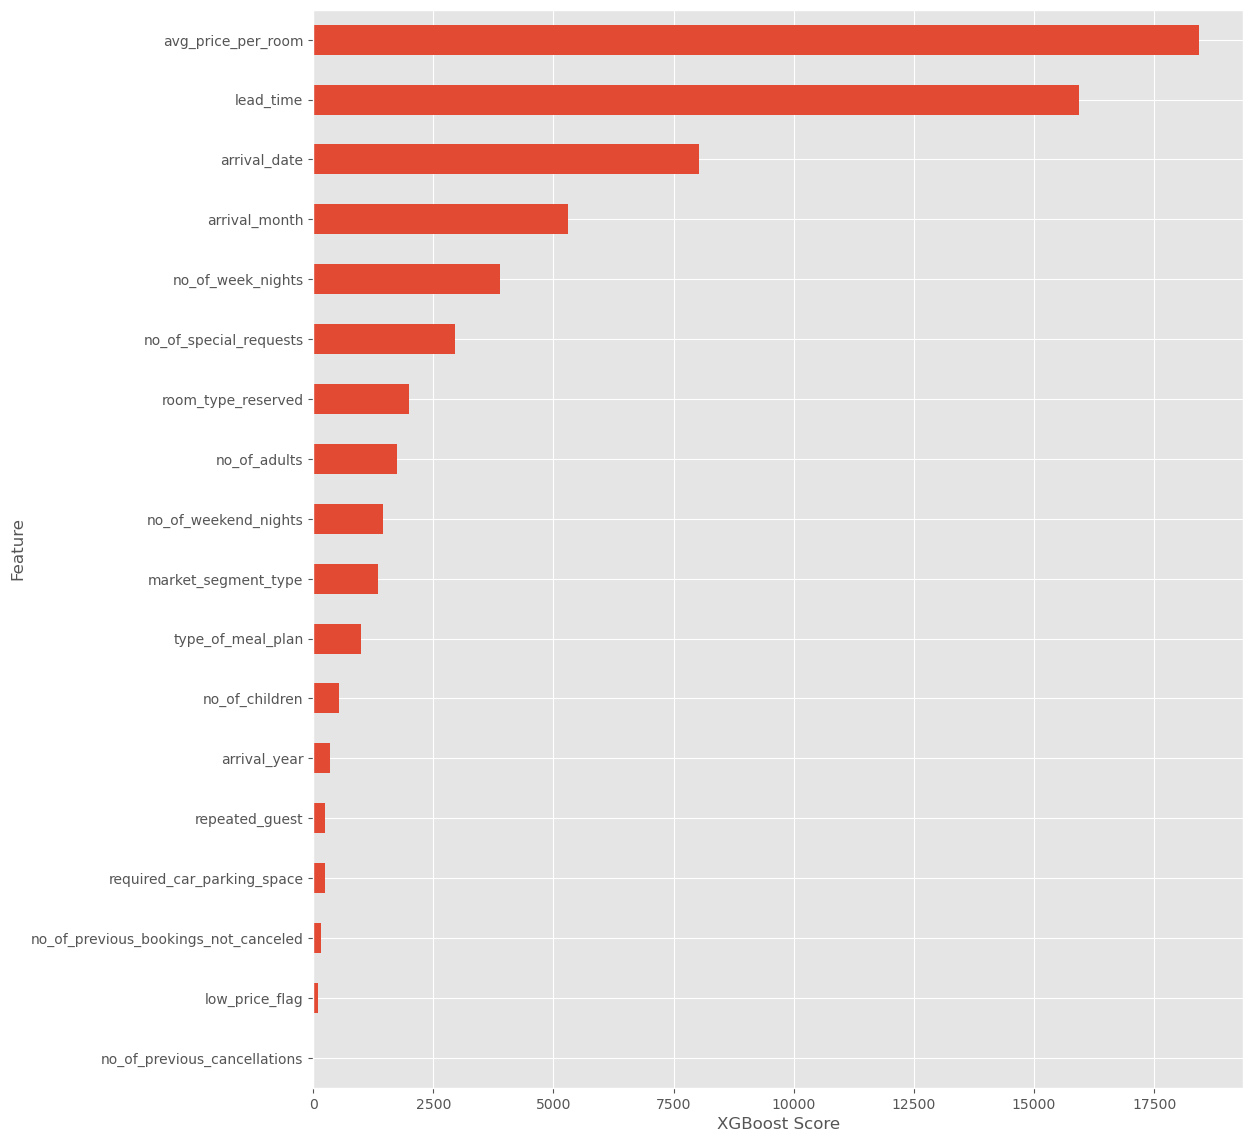

In [5]:
plt.figure(figsize = (12, 14))
pd.DataFrame(lgb_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();

In [6]:
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)
submission['booking_status'] = lgb_preds_test
submission.head()

,id,booking_status
0,42100,0.075531
1,42101,0.096545
2,42102,0.328719
3,42103,0.031375
4,42104,0.452083


In [8]:
submission.describe()

,id,booking_status
count,28068.000000,28068.000000
mean,56133.500000,0.389283
std,8102.678014,0.341880
min,42100.000000,0.000011
25%,49116.750000,0.065435
50%,56133.500000,0.277330
75%,63150.250000,0.736594
max,70167.000000,0.998395


StopIteration: 

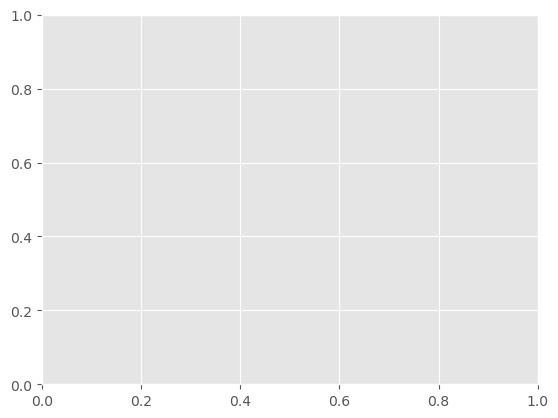

In [9]:
data2 = pd.DataFrame({'Predicted Likelihood': lgb_preds_test})
sns.histplot(data = data2, kde = True, stat = 'density').set(title = 'LightGBM Predicted Likelihood (Optuna) in Test')

In [10]:
submission.to_csv('Baseline_LightGBM_Optuna_price_flag_submission.csv', index = False)